<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/Models_multiinput/modelo_multi_input_predict_energy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow.keras.backend as K
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load info funcs

HAY EVENTOS QUE TIENEN IMAGEN PERO NO ESTAN EN LOS TXT, CUIDAO, LO HE TENIDO QUE ARREGLAR 

In [ ]:
# funcion de carga más personalizada

#primero funcion que carga los datos al darle unos telescopios y runs 
def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=False,ending=".npy",test_size=0.2):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray)):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    else:
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    if only_names:
        return lista
    else:
        if indices_runs is not None:
            if indices_runs[0].size==0:
                no_salir=True
                i=1
                while no_salir:
                    if indices_runs[i].size==0:
                        i+=1
                    else:
                        lista_npy=np.load(lista[i])[indices_runs[i]]
                        no_salir=False
                        i+=1
                for m,k in enumerate(lista[i:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy

        else:
            lista_npy=np.load(lista[0])
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
            return lista_npy

#ahora tenemos que saber cuales son los elementos que se comparten entre todos los telescopios


def get_common_events_energy(npy_dir_base,tels=None,run=None,array_from_txt=None,return_eventos=False):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        if array_from_txt:
            sets=[set(i) for i in array_from_txt]
            eventos_comunes=sorted(list(set(lista[0]).intersection(*sets)))
        else:
            eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        if array_from_txt:
            for i in array_from_txt:
                sets.append(set(i)) 

        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    indices_txt_master=[]
    for i,j in enumerate(tels):
        #no solo queremos que nos devuelva los indices para buscarlo en los npy, tambien para buscarlo en los txt
        indices=[]
        indices_txt=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
            indices_txt.append(np.where(array_from_txt[i]==k)[0][0])
        indices_master.append(np.array(indices))
        indices_txt_master.append(np.array(indices_txt))

    if return_eventos:
        return np.array(indices_master),np.array(indices_txt_master),np.array(eventos_comunes)
    else:
        return np.array(indices_master),np.array(indices_txt_master)



#por ultimo la funcion que nos va a administrar toda la carga de datos, aqui es donde pondemos la funcion de elergir el numero de runs para cada elementos


#MODIFICACION PARA QUE HAYA MAS O MENOS LA MISMA CANTIDAD DE DATOS DE CADA UNO.
def load_dataset_energy(base_dir_npy,base_dir_txt,elementos=None,lista_list_runs=None,pre_name_folders_npy="npy_",pre_name_folders_txt="extract_",
                        telescopios=None,test_size=0.2,same_quant="same",verbose=True,fill=False):
    #LOS TELESCOPIOS EN UNA LISTA AUNQUE SEA 1
    #la estructura de datos esperada es una carpeta contenedora de las carpetas con los archivos npy
    #y prename folder es eso que va delante del nombre de la carpeta que tiene el nombre del elemento

    #los labels son las energis que se obtienen de los txt

    #por ultimo da igual qeu tomemos muchas runs de uno si ponemos same_quant=same se nos quedará la cantidad exacata de cada
    #si ponemos same_quant=aprox mas o menos igual de cada uno  (se toma la mediana de la cantidad total de datos de cada clase considerada)
    #same_quant = "element" existe porque no es lo mis que haya la misma cantida por cada elemento qeu por cada label, entonces hay que tener eso en cuenta

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']


    if len(lista_list_runs)!=len(elementos):
        #como lista_list_runs es una lista de las runs que vamos a tomar, pues deber haber una para cada elemento
        print("Error con la long de los elementos y las runs")
        return None


    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    energia_label=[]
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir_npy}/{pre_name_folders_npy}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        energia_label_aux=[]
        for l,k in enumerate(list_runs):
            #todo esto es para aplicar el get_common events a todas las runs que debemos comprobar
            event_aux=get_txt_info(base_dir_txt,extension=pre_name_folders_txt,cols=0,tel=telescopios,run=k,element=j,cols_order=True)
            #ahora tambien tenemos que estar en concordancia con los eventos que se encuentran en los txt
            aux_events,aux_events_energy=get_common_events_energy(dir_aux,tels=telescopios,run=k,array_from_txt=event_aux,return_eventos=False)

            #ahora tenemos los eventos de cada txt y los que sí se van a usar
            #solo tenemos que conseguir un array con los indices
            if verbose:
                print(j,k,list_runs,aux_events.shape,aux_events_energy.shape)
            energia=get_txt_info(base_dir_txt,extension=pre_name_folders_txt,cols=2,tel=telescopios[0],run=k,element=j,cols_order=True)
            if len(aux_events_energy[0])!=0:
                energia_label_aux.extend(energia[aux_events_energy[0]])

            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        if len(energia_label_aux)!=aux_num_events:
            print("Error con las dimensiones que de labels y features")
            return None
        energia_label.append(np.array(energia_label_aux))
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #esto es lo mas lioso
    #eventos_elementos=[gamma:[run1:[tel1:[eventos en tel1 comunes entre telescopios en run 1 para gamma],tel2:[eventos],...],
                              #run2:[tel1:[eventos],tel2:[ev...]],run3:[...]] ,electron:[run1:[...],run2:[...]],....]


    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]

    if verbose:
        print("_______________")

    
    if (same_quant=="approx") :
        cantidad=int(np.median(numero_eventos))
        print(cantidad)

            
    elif (same_quant=="same") :
        cantidad=int(np.amin(numero_eventos))
        print(cantidad)


    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir_npy}/{pre_name_folders_npy}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES/eventos QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)

            if same_quant in ["same","approx"]:
                data_aux=data_aux[:cantidad]
                if l==0:
                    energia_label[i]=energia_label[i][:cantidad]
            elif same_quant=="all":
                pass

            if fill:
                #aplicamos la funcion que nos rellena todo
                for p in range(data_aux.shape[0]):
                    data_aux[p,:,:]=fill_holes(data_aux[p])

            if verbose:
                print(j,k,data_aux.shape)
                if l==0:
                    print(energia_label[i].shape)
            if i==0 :
                data=data_aux
            else:
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            energia_label=np.concatenate([h for h in energia_label])
            print(energia_label.shape,data.shape)
            x_train,x_test,y_train,y_test =train_test_split(data,energia_label,test_size=test_size,random_state=42)
            del data
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data

        if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
            print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
            return None
        del x_train,x_test

    print("EXITO")
    if len(telescopios)==1:
        return x_train_list[0],x_test_list[0],y_train_list,y_test_list
    else:
        return x_train_list,x_test_list,y_train_list,y_test_list

In [ ]:
a=create_lista_list_runs(num_events=[2,2,2,2,2,2,2],init_events=np.ones(7),random_select=False)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,y_train,y_test=load_dataset_energy(npy_base,dir_base_txt,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
                                                    ,lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="approx",verbose=True,fill=False)


In [ ]:
#una funcion para crear la lista de list runs 
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]-1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+1,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)


            else:
                if (j) > max_runs[i]:
                    print(f"Error, para el \"{elementos[i]}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)

def fill_holes(npy):
    npy_aux=npy.copy()
    if type(npy)!=np.ndarray:
        print("Error input")
        return
    #para cada elemento que sea cero lo rellenamos con la media de los vecinos
    indices=np.where(npy[1:-1,1:-1]==0)
    indices_1=indices[1]+1
    indices_0=indices[0]+1
    for i in range(indices_1.shape[0]):
        #esto se podría vectorizar
        media=(npy[indices_0[i]-1,indices_1[i]]+npy[indices_0[i],indices_1[i]-1]+npy[indices_0[i]+1,indices_1[i]]+npy[indices_0[i],indices_1[i]+1])/4
        npy_aux[indices_0[i],indices_1[i]]=media
    del npy
    return npy_aux




#extract info txt


In [ ]:
def lista_dt(dt_dir):
    return sorted(glob.glob(f"{dt_dir}/*.dt"))
def lista_txt(txt_dir):
    return sorted(glob.glob(f"{txt_dir}/*.txt"))

In [ ]:
def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
    cols_names=["event"
    ,"telescope"
    ,"energy"
    ,"core distance to telescope"
    ,"image size (amplitude) [p.e.]"
    ,"number of pixels in image"
    ,"width [deg.]"
    ,"length [deg.]"
    ,"distance [deg.]"
    ,"miss [deg.]"
    ,"alpha [deg.]"
    ,"orientation [deg.]"
    ,"direction [deg.]"
    ,"image c.o.g. x [deg.]"
    ,"image c.o.g. y [deg.]"
    ,"Xmax [g/cm^2]"
    ,"Hmax [m]"
    ,"Npe (true number of photo-electrons)"
    ,"(19-23): Hottest pixel amplitudes)"]
    with open(txt_dir,"r") as file:
        text_aux=file.read()
        a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
        a=[i.replace("@+ ","").split() for i in a]
    if cols is None:
        return np.array(a).astype("float")
    elif type(cols)==list or type(cols)==np.array:
        list_aux=[]
        if cols_order :
            for i in cols:
                list_aux.append(np.array([float(j[i]) for j in a]))
            return np.array(list_aux).astype("float")
        else:
            list_aux=[]
            for i in a:
                list_aux.append(np.array([i[j] for j in cols ]))
            return np.array(list_aux).astype("float")

    else:
        return np.array([float(j[cols]) for j in a]).astype("float")

In [ ]:
#ahora necesitamos poder indicar el telescopio, la run y el elemento para que nos lo devulve
def get_txt_info(base_dir,extension="extract_",tel=None,run=None,element=None,cols=None,cols_order=True,ending=".txt"):
    if (type(tel)==list) or (type(tel)==np.ndarray):
        list_return=[]
        for i in tel:
            regex=f"{base_dir}/{extension}{element}/{element}_tel_{i}_run_{str(run).zfill(2)}{ending}"
            aux=glob.glob(regex)
            if aux:
                list_return_aux=extract_info_txt(aux[0],cols=cols,cols_order=cols_order)
                list_return.append(list_return_aux)
            else:
                print("Error, archivo no encontrado")
                return None
    else:
        regex=f"{base_dir}/{extension}{element}/{element}_tel_{tel}_run_{str(run).zfill(2)}{ending}"
        aux=glob.glob(regex)
        if aux:
            list_return=extract_info_txt(aux[0],cols=cols,cols_order=cols_order)
        else:
            print("Error, archivo no encontrado")
            return None

    return list_return

# Modelo y entrenamiento


In [ ]:
def model_1_tel(input_shape=(55,93,1),filtros=None,batch_init=True,last_layers=None,avg_pooling=None,learning_rate=1e-5,first_model=None,first_part=False):
    if filtros is None:
        filtros=[[64,32],[128,64,64],[32,16]]
    if last_layers is None:
        last_layer=[35,20]
    #lo vamos a hacer super customizable para probar esa vaina de entrenar muchos hiperparametros
    #estructura lo que nos mete son el numero de filtros conv y maxpool
    model=tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape)])
    if first_model:
        first_model.trainable=False
        model.add(first_model)
    if batch_init:
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
    for i,j in enumerate(filtros):
        #aqui se alterna entre conv y maxpool(1) o average pool(-1)
        for k in j:
            model.add(tf.keras.layers.Conv2D(k,3,activation="relu"))
        if avg_pooling:
            model.add(tf.keras.layers.AveragePooling2D((2,2)))
        else:
            model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    if first_part:
        return model
    for j,i in enumerate(last_layers):
        model.add(tf.keras.layers.Dense(i,activation="relu"))
    model.add(tf.keras.layers.Dense(classes,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


def model_multi_tel(len_inputs=4,input_shapes=[(55,93,1)],learning_rate=1e-5,pre_proces_model=None,batch_init=False,filtros=None,last_dense=None,autoencoder=None,common_pre=True):
    inputs=[]
    outputs=[[] for i in range(len_inputs)]
    if len(input_shapes)==1:
        for i in range(1,len_inputs):
            input_shapes.append(input_shapes[0])

    for i in range(len_inputs):
        inputs.append(tf.keras.Input(shape=input_shapes[i]))

    if pre_proces_model:
        for i in range(len_inputs):
            outputs[i]=pre_proces_model(inputs[i],first_model=autoencoder)
    else:
        if filtros is None:
            filtros=[[64,128],[128,254,64],[32]]
        #si no le metemos un modelo pues habra que meter aqui chicha porque sino se queda esto muy vacio
        if common_pre:
            pre_model=model_1_tel(input_shapes[0],batch_init=batch_init,filtros=filtros,first_part=True,first_model=autoencoder)
            outputs[0]=pre_model(inputs[0])
            for i in range(1,len_inputs):
                if input_shapes[i]!=input_shapes[i-1]:
                #esto esta suponiendo que ponemos juntos los que tienen igual shape
                    pre_model=model_1_tel(input_shapes[i],batch_init=batch_init,filtros=filtros,first_part=True,first_model=autoencoder) 
                outputs[i]=pre_model(inputs[i])

        else:
            for i in range(len_inputs):
                pre_model=model_1_tel(input_shape=input_shapes[i],batch_init=batch_init,filtros=filtros,first_part=True)
                outputs[i]=pre_model(inputs[i]) 
    #nos falta la ultima parte
    if last_dense is None:
        last_dense=[65,25]
    x=tf.keras.layers.concatenate(outputs)
    for i in last_dense:
        x=tf.keras.layers.Dense(i,activation="relu",kernel_regularizer="l2")(x)
    end_layer=tf.keras.layers.Dense(1)(x)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="mse")

    return model


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 84, 56, 1)]  0                                            
____________________________________________________________________________________________

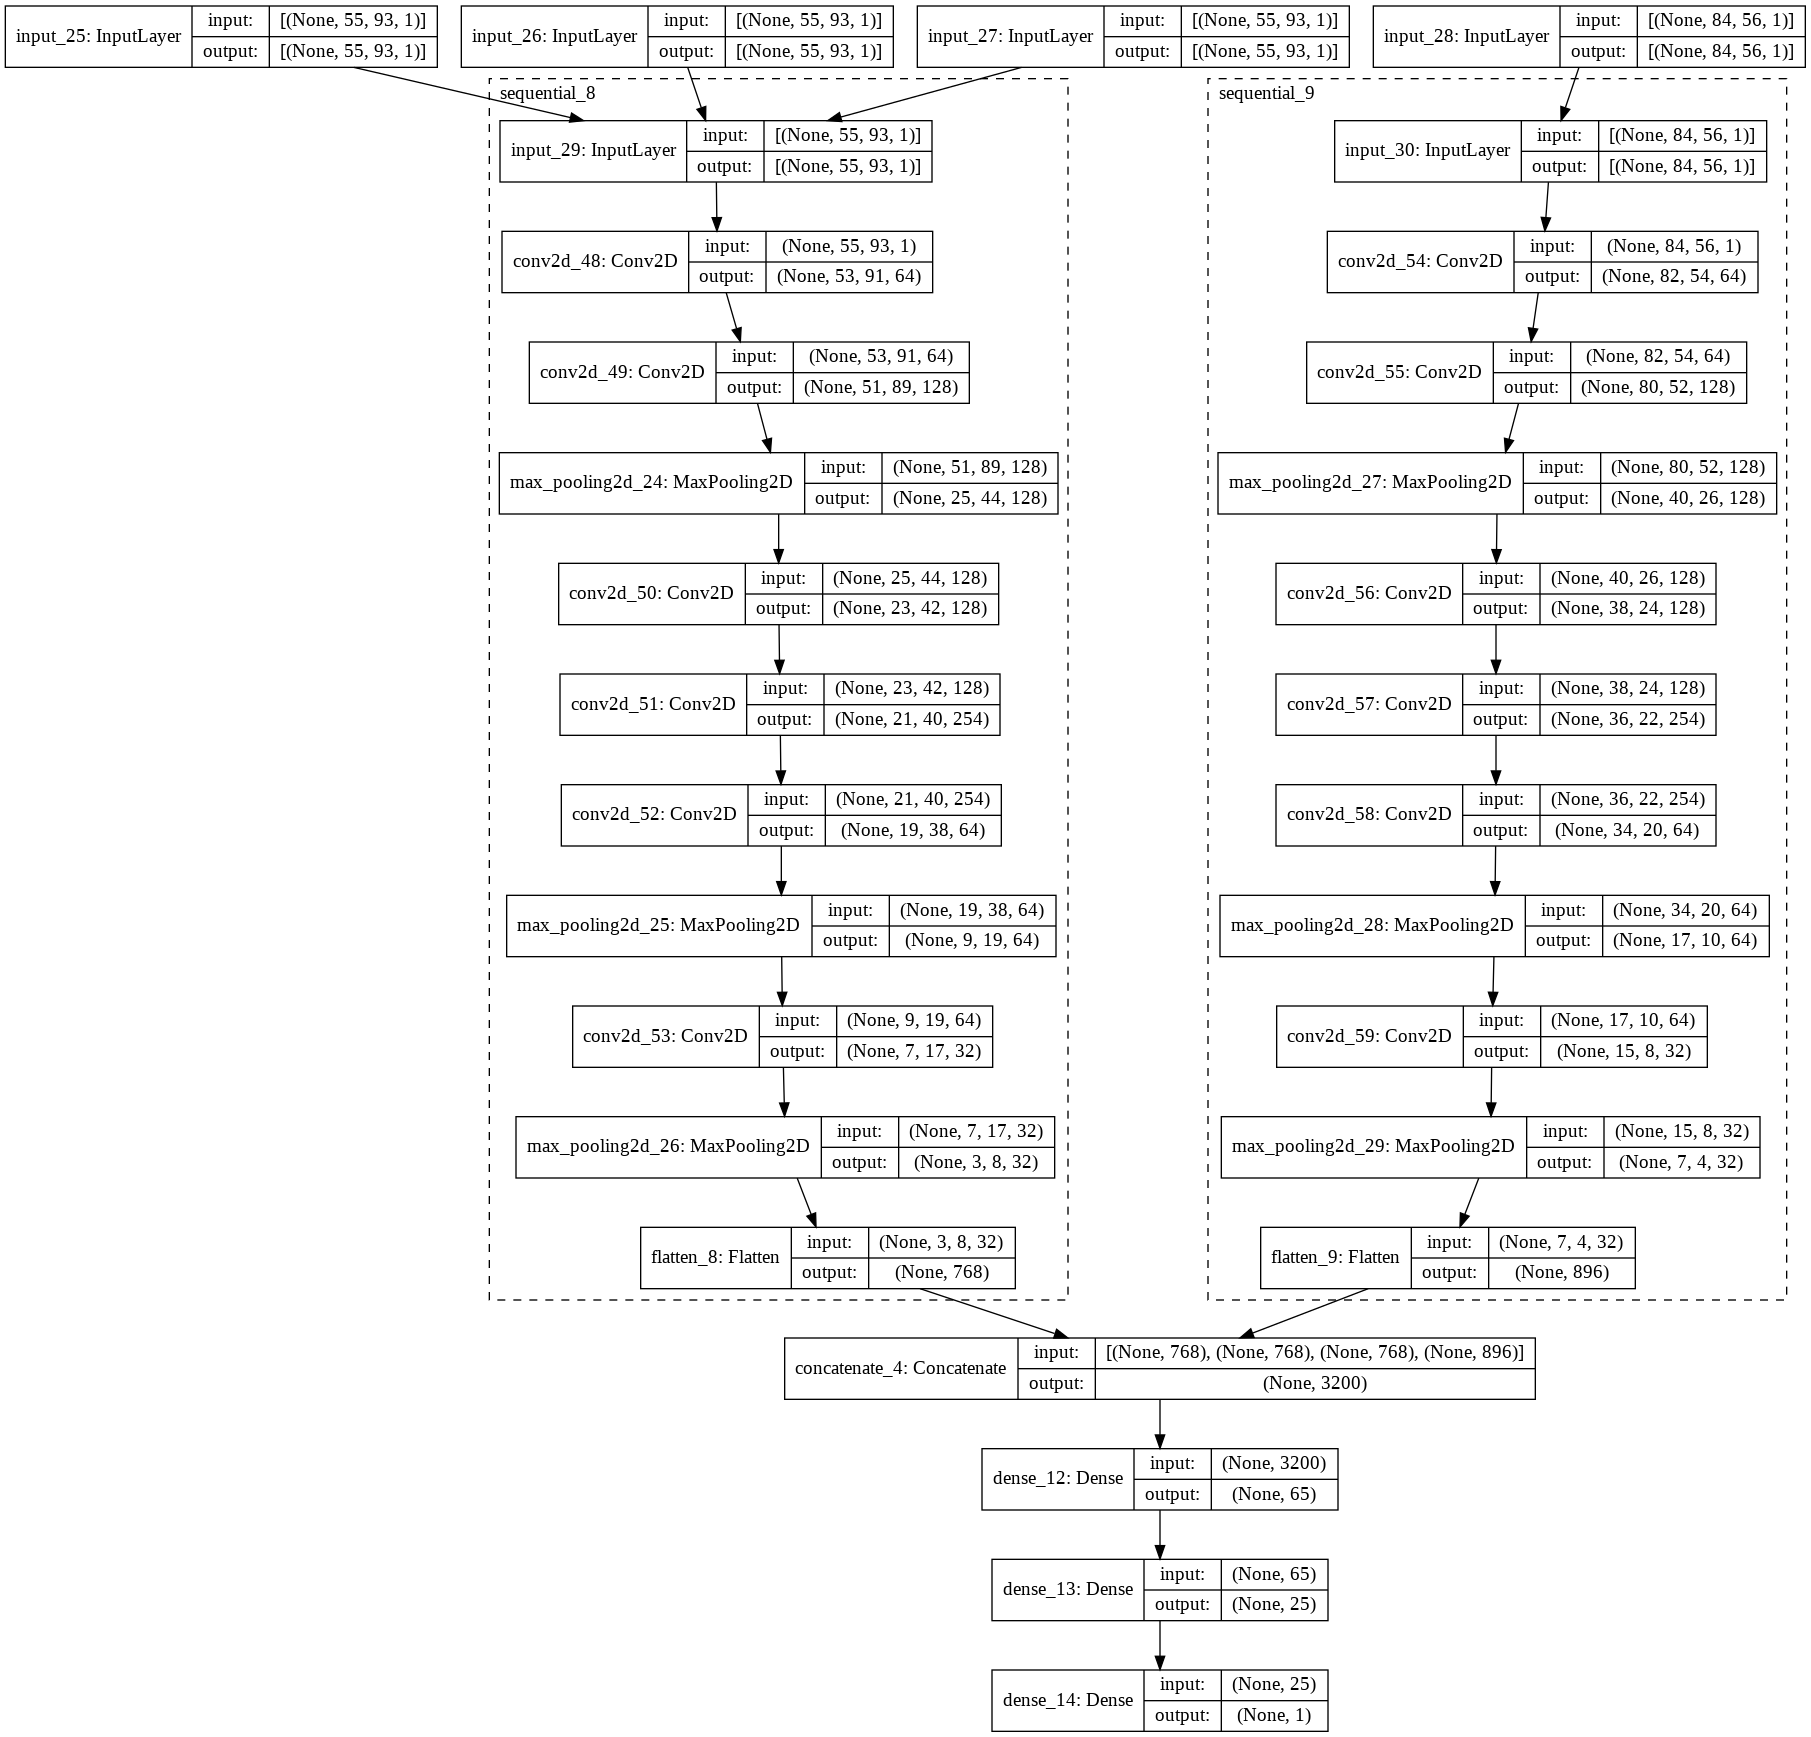

In [ ]:
model=model_multi_tel(learning_rate=1e-4,input_shapes=[(55,93,1),(55,93,1),(55,93,1),(84,56,1)],batch_init=False,common_pre=True)
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)


In [ ]:
a=create_lista_list_runs(num_events=[4,30,30,30,20,30,30],init_events=np.ones(7),random_select=False)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
dir_base_txt="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
x_train,x_test,y_train,y_test=load_dataset_energy(npy_base,dir_base_txt,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
                                                    ,lista_list_runs=a,telescopios=[4,5,6,31],test_size=0.2,same_quant="all",verbose=True,fill=False)


Error, para el 4 te estas pasando de run, no hay runs [21 22]
gamma 1 [1 2 3 4] (4, 782) (4, 782)
gamma 2 [1 2 3 4] (4, 780) (4, 780)
gamma 3 [1 2 3 4] (4, 774) (4, 774)
gamma 4 [1 2 3 4] (4, 809) (4, 809)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] (4, 48) (4, 48)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] (4, 47) (4, 47)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] (4, 43) (4, 43)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] (4, 50) (4, 50)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] (4, 52) (4, 52)
electron 6 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] (4, 52) (4, 52)
electron 7 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21

In [ ]:
for i in range(4):
    print(x_train[i].shape,y_train.shape,x_test[i].shape,y_test.shape)

(8561, 55, 93, 1) (8561,) (2141, 55, 93, 1) (2141,)
(8561, 55, 93, 1) (8561,) (2141, 55, 93, 1) (2141,)
(8561, 55, 93, 1) (8561,) (2141, 55, 93, 1) (2141,)
(8561, 84, 56, 1) (8561,) (2141, 84, 56, 1) (2141,)


In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)
hist=model.fit(x_train,y_train,epochs=56,batch_size=16,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/56
500/500 [==============================] - 21s 43ms/step - loss: 0.3260 - val_loss: 0.2971
Epoch 2/56
500/500 [==============================] - 21s 42ms/step - loss: 0.2555 - val_loss: 0.3084
Epoch 3/56
500/500 [==============================] - 21s 42ms/step - loss: 0.1853 - val_loss: 0.3396
Epoch 4/56
500/500 [==============================] - 21s 42ms/step - loss: 0.1138 - val_loss: 0.3381
Epoch 5/56
500/500 [==============================] - 21s 42ms/step - loss: 0.0740 - val_loss: 0.3509
Epoch 6/56
500/500 [==============================] - 21s 42ms/step - loss: 0.0609 - val_loss: 0.3359
Epoch 7/56
500/500 [==============================] - 21s 42ms/step - loss: 0.0552 - val_loss: 0.3432
Epoch 8/56
500/500 [==============================] - 21s 42ms/step - loss: 0.0542 - val_loss: 0.3321
Epoch 9/56
500/500 [==============================] - 21s 42ms/step - loss: 0.0554 - val_loss: 0.3291
Epoch 10/56
500/500 [==============================] - 21s 42ms/step - loss: 0.052

In [ ]:
y_predict=model.predict(x_test)


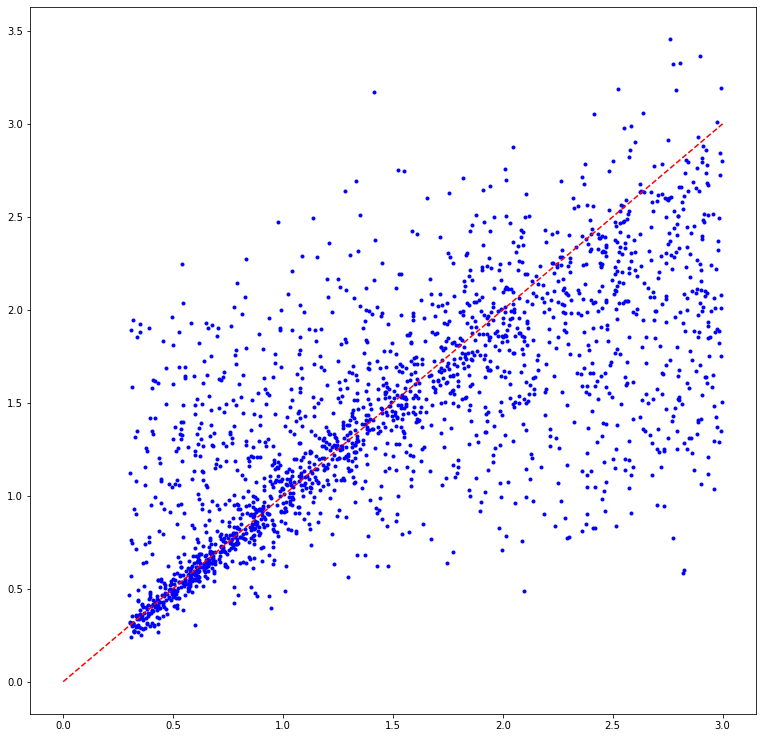

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(y_test,y_predict,".b")
plt.plot([0,3],[0,3],"--r")

In [ ]:
np.all(y_predict==1)

True